# SOLVERS ONLINE

## PREPARING THE DEVELOPMENT ENVIRONMENT

Including path to previous directory in built-in variable `sys.path`, allowing access to the `maze` package:

In [1]:
import sys

sys.path.append('../')

Importing the libraries:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from maze.generators import DFSMazeGenerator,  \
                            PrimMazeGenerator, \
                            KruskalMazeGenerator

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Auxiliary function to print the maze and the intelligent agent:

- `(x, y)` represents the position of the agent

In [3]:
def is_conn(graph, v, w):
    return v in graph[w]

def get_character(maze, x, y, r, c):
    return 'X' if x == c and y == r else 'O'

def get_row(maze, r, c, n):
    v = n * r + c

    return ' ' if is_conn(maze, v, v+1) else '|'

def get_col(maze, r, c, n):
    v = n * r + c

    return '  ' if is_conn(maze, v, v+n) else '_ '

def print_maze(n, maze, x, y):
    for r in range(n):
        for c in range(n-1):
            print(get_character(maze, x, y, r, c),
                  end=get_row(maze, r, c, n))

        print(get_character(maze, x, y, r, c+1))

        if r != n-1:
            for c in range(n):
                print(end=get_col(maze, r, c, n))

            print()

## MAZE LOGIC

Implementing maze logic:

- Class responsible for the maze
- The constructor generates a new grid that represents a maze
- Default is a 10x10 grid
- Getitem checks for the existence of an edge between two vertices

In [4]:
class Maze:
    def __init__(self, generator, n=100):
        self.n = n
        self.shape = int(n**0.5)

        self.grid  = generator(n).generate_maze()

    def __getitem__(self, move):
        pre, pos = move

        if 0 <= pos < self.n:
            return pre in self.grid[pos]

        return False

    def won(self, x, y):
        return x == y == self.shape-1

Developing the class responsible for the game character:

- Starts at position `(0, 0)`

In [5]:
class Fiancee:
    def __init__(self):
        self.x = 0
        self.y = 0

    def move(self, move):
        if (move == 'u'):
            self.y -= 1
        elif (move == 'd'):
            self.y += 1
        elif (move == 'l'):
            self.x -= 1
        elif (move == 'r'):
            self.x += 1

    @property
    def xy(self):
        return self.x, self.y

## ONLINE DFS AGENT

Defining constants and a dictionary that pairs movements with their corresponding reversals:




In [6]:
UNSUCCESS = -1
PERFORM = 0
SUCCESS = 1

undone = {'u' : 'd',
          'd' : 'u',
          'r' : 'l',
          'l' : 'r'}

Implementing the online dfs agent:

- Step online function: the `step_online` function takes a percept s as an argument, which identifies the current state of the agent within the environment
- Ensuring search status: within the `step_online` function, it's crucial to verify the search status to ensure that the agent's exploration or search process is correctly ongoing

In [7]:
class OnlineDFSAgent:
    def __init__(self):
        self.result  = defaultdict(lambda: None)
        self.untried = defaultdict(list)
        self.unback  = defaultdict(list)

        self.s = None
        self.a = None

        self.status = PERFORM

    def step_online(self, maze, s):
        if self.status != PERFORM:
            return None
        if maze.won(*s):
            self.status = SUCCESS
            return None

        if not self.step(maze, s):
            self.status = UNSUCCESS

        return self.a

    def step(self, maze, s):
        if s not in self.untried:
            self.untried[s] = self.actions(maze, s)

        if self.s and s != self.result[self.s, self.a]:
            self.result[self.s, self.a]    = s
            self.result[s, undone[self.a]] = self.s

            self.unback[s].append(undone[self.a])

        self.s = s
        if self.untried[s]:
            self.a = self.untried[s].pop()
        elif self.unback[s]:
            self.a = self.unback[s].pop()
        else:
            self.a = None

        return self.a

    def actions(self, maze, p):
        actions = []

        pos = p[0] + maze.shape*p[1]

        if self.a != 'r' and maze[pos, pos-1]:
            actions.append('l')
        if self.a != 'l' and maze[pos, pos+1]:
            actions.append('r')
        if self.a != 'd' and maze[pos, pos-maze.shape]:
            actions.append('u')
        if self.a != 'u' and maze[pos, pos+maze.shape]:
            actions.append('d')

        return actions

    @property
    def path(self):
        path = [self.s]

        p = path[-1]
        while p != (0, 0):
            p = self.result[p, self.unback[p][0]]
            path.append(p)

        return path[::-1]

Testing the agent:

In [8]:
maze = Maze(DFSMazeGenerator)

In [9]:
agent = OnlineDFSAgent()
fianc = Fiancee()

print_maze(maze.shape, maze.grid, *fianc.xy)

steps = 0
while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)
        steps += 1

print()
print()

print_maze(maze.shape, maze.grid, *fianc.xy)

X O|O O|O O O|O O O
_             _     
O|O O|O|O|O|O O|O|O
  _ _   _   _       
O O|O|O O O|O O|O|O
      _ _ _   _ _   
O|O|O O O O|O O O O
      _ _   _ _ _   
O|O O|O O O|O O|O|O
  _ _   _ _         
O|O O O O O O|O O|O
  _ _ _ _ _ _   _   
O O O|O O O|O O|O O
  _     _   _ _   _ 
O|O O|O|O|O O O O|O
          _ _ _ _   
O|O|O|O|O O O O|O O
    _   _   _   _   
O|O O O O O|O O O O


O O|O O|O O O|O O O
_             _     
O|O O|O|O|O|O O|O|O
  _ _   _   _       
O O|O|O O O|O O|O|O
      _ _ _   _ _   
O|O|O O O O|O O O O
      _ _   _ _ _   
O|O O|O O O|O O|O|O
  _ _   _ _         
O|O O O O O O|O O|O
  _ _ _ _ _ _   _   
O O O|O O O|O O|O O
  _     _   _ _   _ 
O|O O|O|O|O O O O|O
          _ _ _ _   
O|O|O|O|O O O O|O O
    _   _   _   _   
O|O O O O O|O O O X


In [10]:
print('Size of the path =', len(agent.path) + 1)
print('Number of steps  =', steps)
print('Final position   =', fianc.xy)

Size of the path = 43
Number of steps  = 42
Final position   = (9, 9)


## LRTA* AGENT

Implementing the LRTA* agent:

In [11]:
class LRTAStar:
    def __init__(self):
        self.R = defaultdict(lambda: None)
        self.H = dict()
        
        self.s = None
        self.a = None
        
        self.status = PERFORM
        
    def step_online(self, maze, s):
        if self.status != PERFORM:
            return None
        if maze.won(*s):
            self.status = SUCCESS
            return None

        return self.step(maze, s)

    def step(self, maze, s):
        shape = maze.shape - 1

        if s not in self.H:
            self.H[s] = self.dist(shape, *s)
        if self.s:
            self.R[self.s, self.a] = s
            self.H[self.s] = min(self.cost(shape, self.s, self.R[self.s, act])
                                 for act in self.actions(maze, self.s))

        self.s = s
        self.a = min([act for act in self.actions(maze, s)],
                     key=lambda act: self.cost(shape, s, self.R[s, act]))        

        return self.a

    def actions(self, maze, p):
        actions = []

        place = p[0] + maze.shape*p[1]

        if maze[place, place-1]:
            actions.append('l')
        if maze[place, place+1]:
            actions.append('r')
        if maze[place, place-maze.shape]:
            actions.append('u')
        if maze[place, place+maze.shape]:
            actions.append('d')

        return actions

    def cost(self, shape, s, s_):
        return 1 + self.H[s_] \
               if s_          \
               else self.dist(shape, *s)

    @staticmethod
    def dist(shape, x, y):
        return (shape - x) + (shape - y)

Testing the agent:

In [12]:
agent = LRTAStar()
fianc = Fiancee()

print_maze(maze.shape, maze.grid, *fianc.xy)

steps = 0
while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)
        steps += 1

print()
print()

print_maze(maze.shape, maze.grid, *fianc.xy)

X O|O O|O O O|O O O
_             _     
O|O O|O|O|O|O O|O|O
  _ _   _   _       
O O|O|O O O|O O|O|O
      _ _ _   _ _   
O|O|O O O O|O O O O
      _ _   _ _ _   
O|O O|O O O|O O|O|O
  _ _   _ _         
O|O O O O O O|O O|O
  _ _ _ _ _ _   _   
O O O|O O O|O O|O O
  _     _   _ _   _ 
O|O O|O|O|O O O O|O
          _ _ _ _   
O|O|O|O|O O O O|O O
    _   _   _   _   
O|O O O O O|O O O O


O O|O O|O O O|O O O
_             _     
O|O O|O|O|O|O O|O|O
  _ _   _   _       
O O|O|O O O|O O|O|O
      _ _ _   _ _   
O|O|O O O O|O O O O
      _ _   _ _ _   
O|O O|O O O|O O|O|O
  _ _   _ _         
O|O O O O O O|O O|O
  _ _ _ _ _ _   _   
O O O|O O O|O O|O O
  _     _   _ _   _ 
O|O O|O|O|O O O O|O
          _ _ _ _   
O|O|O|O|O O O O|O O
    _   _   _   _   
O|O O O O O|O O O X


In [13]:
print('Number of steps  =', steps)
print('Final position   =', fianc.xy)

Number of steps  = 236
Final position   = (9, 9)


## TESTS

Comparison between the average number of steps used by each search method for each type of maze instance generator:

- Declaring a function to perform the search on each instance and obtain the average number of steps
- Creating 100 random instances for each distinct maze generator

In [14]:
def benchmark(mazes, size):
    steps_odfs = 0
    steps_lrta = 0

    for maze in mazes:
        agent_odfs = OnlineDFSAgent()
        agent_lrta = LRTAStar()
        fianc_odfs = Fiancee()
        fianc_lrta = Fiancee()

        while agent_odfs.status == PERFORM:
            act = agent_odfs.step_online(maze, fianc_odfs.xy)

            if act:
                fianc_odfs.move(act)
                steps_odfs += 1

        while agent_lrta.status == PERFORM:
            act = agent_lrta.step_online(maze, fianc_lrta.xy)

            if act:
                fianc_lrta.move(act)
                steps_lrta += 1

    return steps_odfs / size, steps_lrta / size

In [15]:
N = 100

mazes_dfs     = [Maze(DFSMazeGenerator)     for _ in range(N)]
mazes_prim    = [Maze(PrimMazeGenerator)    for _ in range(N)]
mazes_kruskal = [Maze(KruskalMazeGenerator) for _ in range(N)]

steps_odfs_dfs    , steps_lrta_dfs     = benchmark(mazes_dfs, len(mazes_dfs))
steps_odfs_prim   , steps_lrta_prim    = benchmark(mazes_prim, len(mazes_prim))
steps_odfs_kruskal, steps_lrta_kruskal = benchmark(mazes_kruskal, len(mazes_kruskal))

agent     = ['DFSSearch', 'DFSSearch', 'DFSSearch',
             'LRTAStar', 'LRTAStar', 'LRTAStar']
generator = ['DFS', 'Prim', 'Kruskal', 'DFS', 'Prim', 'Kruskal']
steps     = [steps_odfs_dfs, steps_odfs_prim, steps_odfs_kruskal,
             steps_lrta_dfs, steps_lrta_prim, steps_lrta_kruskal]

data = pd.DataFrame({'agent'     : agent,
                     'generator' : generator,
                     'steps'     : steps})
data

,agent,generator,steps
0,DFSSearch,DFS,46.96
1,DFSSearch,Prim,89.20
2,DFSSearch,Kruskal,77.50
3,LRTAStar,DFS,260.62
4,LRTAStar,Prim,194.38
5,LRTAStar,Kruskal,194.46


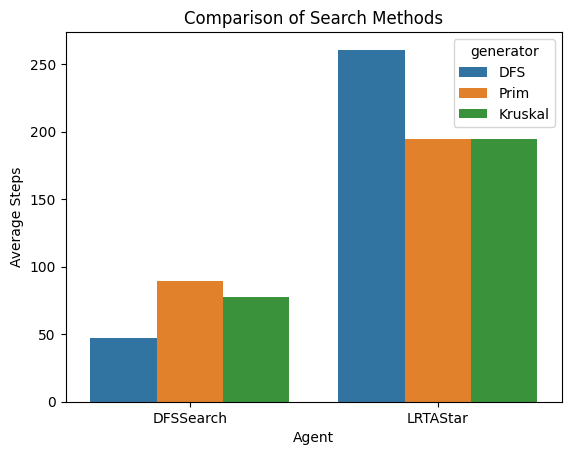

In [16]:
sns.barplot(data, x='agent', y='steps', hue='generator')

plt.xlabel('Agent')
plt.ylabel('Average Steps')
plt.title('Comparison of Search Methods')

plt.show()

Comparison of method efficiency on a random instance created with `DFSGenerator`:


In [17]:
maze = mazes_dfs[0]

In [18]:
%%timeit

agent = OnlineDFSAgent()
fianc = Fiancee()

while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)

234 µs ± 8.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%%timeit

agent = LRTAStar()
fianc = Fiancee()

while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)

2.26 ms ± 58.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Comparison of method efficiency on a random instance created with `PrimGenerator`:

In [20]:
maze = mazes_prim[0]

In [21]:
%%timeit

agent = OnlineDFSAgent()
fianc = Fiancee()

while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)

537 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%timeit

agent = LRTAStar()
fianc = Fiancee()

while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)

2.95 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Comparison of method efficiency on a random instance created with `KruskalGenerator`:

In [23]:
maze = mazes_kruskal[0]

In [24]:
%%timeit

agent = OnlineDFSAgent()
fianc = Fiancee()

while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)

376 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%%timeit

agent = LRTAStar()
fianc = Fiancee()

while agent.status == PERFORM:
    act = agent.step_online(maze, fianc.xy)

    if act:
        fianc.move(act)

6.78 ms ± 97.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
